# La Palma 2021 Erruption data gathering and visualization

## Importing libraries

In [1]:
%matplotlib inline

from datetime import datetime as dt
from datetime import timedelta

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import contextily as cx
import matplotlib.ticker as mticker

from SeismicPortal.dl_quakes import CANARY_BOX, SeismicPortal

sns.set_theme()
plt.rcParams['figure.figsize'] = [30, 15]


## Downloading latest eartquake data for the Canary Islands

In [2]:
sp = SeismicPortal()
# results = sp.download_earthquakes(start_time=dt.now() - timedelta(days=14), **CANARY_BOX)
results = sp.download_earthquakes(start_time=dt.now() - timedelta(days=60), **CANARY_BOX)

1665 earthquakes downloaded.


In [3]:
master_df = pd.DataFrame([q.get("properties") for q in results])

# Tranform data

# Remove timezone info to remove numpy deprecation warning
master_df["time"] = master_df["time"].apply(lambda x: x.strip("Z"))
master_df["lastupdate"] = master_df["lastupdate"].apply(lambda x: x.strip("Z"))

master_df["lastupdate"] = pd.to_datetime(master_df["lastupdate"])
master_df["time"] = pd.to_datetime(master_df["time"])
master_df["date"] = master_df["time"].dt.date

# Enhance data

# Create magnitude bins

m_bins = [
    pd.Interval(left=0, right=2),
    pd.Interval(left=2, right=3),
    pd.Interval(left=3, right=4),
    pd.Interval(left=4, right=5),
    pd.Interval(left=5, right=float("inf"))
]

# m_bins_small = [
#     pd.Interval(left=-float("inf"), right=3),
#     pd.Interval(left=3, right=float("inf")),
# ]

magnitude_ranges = []
for index, row in master_df.iterrows():
    for r in m_bins:
        if row["mag"] in r:
            magnitude_ranges.append(r)

master_df['mag_range'] = magnitude_ranges

# Auto create bins
# master_df['mag_range'] = pd.cut(master_df['mag'], bins = 5)

# Add mean magnitude and depth per day

master_df = pd.merge(master_df, master_df.groupby("date").mean().round(decimals=3)[["mag", "depth"]], on="date", suffixes=("", "_mean"), how="right")

master_df = master_df.sort_values("time", ascending=False, ignore_index=True)
master_df


,lastupdate,magtype,evtype,lon,auth,lat,depth,unid,mag,time,source_id,source_catalog,flynn_region,date,mag_range,mag_mean,depth_mean
0,2021-10-08 17:39:00,ml,ke,-17.84,MDD,28.56,14.0,20211008_0000218,2.8,2021-10-08 17:30:02.800,1045728,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(2, 3]",2.868,13.623
1,2021-10-08 16:41:00,ml,ke,-17.84,MDD,28.57,11.0,20211008_0000211,2.7,2021-10-08 16:26:03.700,1045719,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(2, 3]",2.868,13.623
2,2021-10-08 16:28:00,ml,ke,-17.83,MDD,28.56,13.0,20211008_0000202,3.4,2021-10-08 16:09:44.300,1045708,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(3, 4]",2.868,13.623
3,2021-10-08 15:49:00,ml,ke,-17.84,MDD,28.57,13.0,20211008_0000199,2.7,2021-10-08 15:44:39.300,1045704,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(2, 3]",2.868,13.623
4,2021-10-08 13:34:00,ml,ke,-17.85,MDD,28.57,10.0,20211008_0000175,2.6,2021-10-08 13:24:33.200,1045677,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(2, 3]",2.868,13.623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,2021-08-11 07:13:00,ml,ke,-16.30,MDD,27.98,24.0,20210811_0000062,1.5,2021-08-11 06:25:15.700,1022075,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(0, 2]",1.925,21.000
1661,2021-08-11 02:50:00,ml,ke,-16.20,MDD,28.15,15.0,20210811_0000017,1.5,2021-08-11 02:34:55.400,1022018,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(0, 2]",1.925,21.000
1662,2021-08-10 12:58:00,ml,ke,-16.30,MDD,28.09,36.0,20210810_0000109,1.9,2021-08-10 12:18:02.900,1021785,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-10,"(0, 2]",1.900,36.000
1663,2021-08-09 23:38:00,ml,ke,-18.00,MDD,27.69,22.0,20210809_0000247,2.1,2021-08-09 23:02:22.900,1021619,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-09,"(2, 3]",1.800,13.000


## Visualization of data

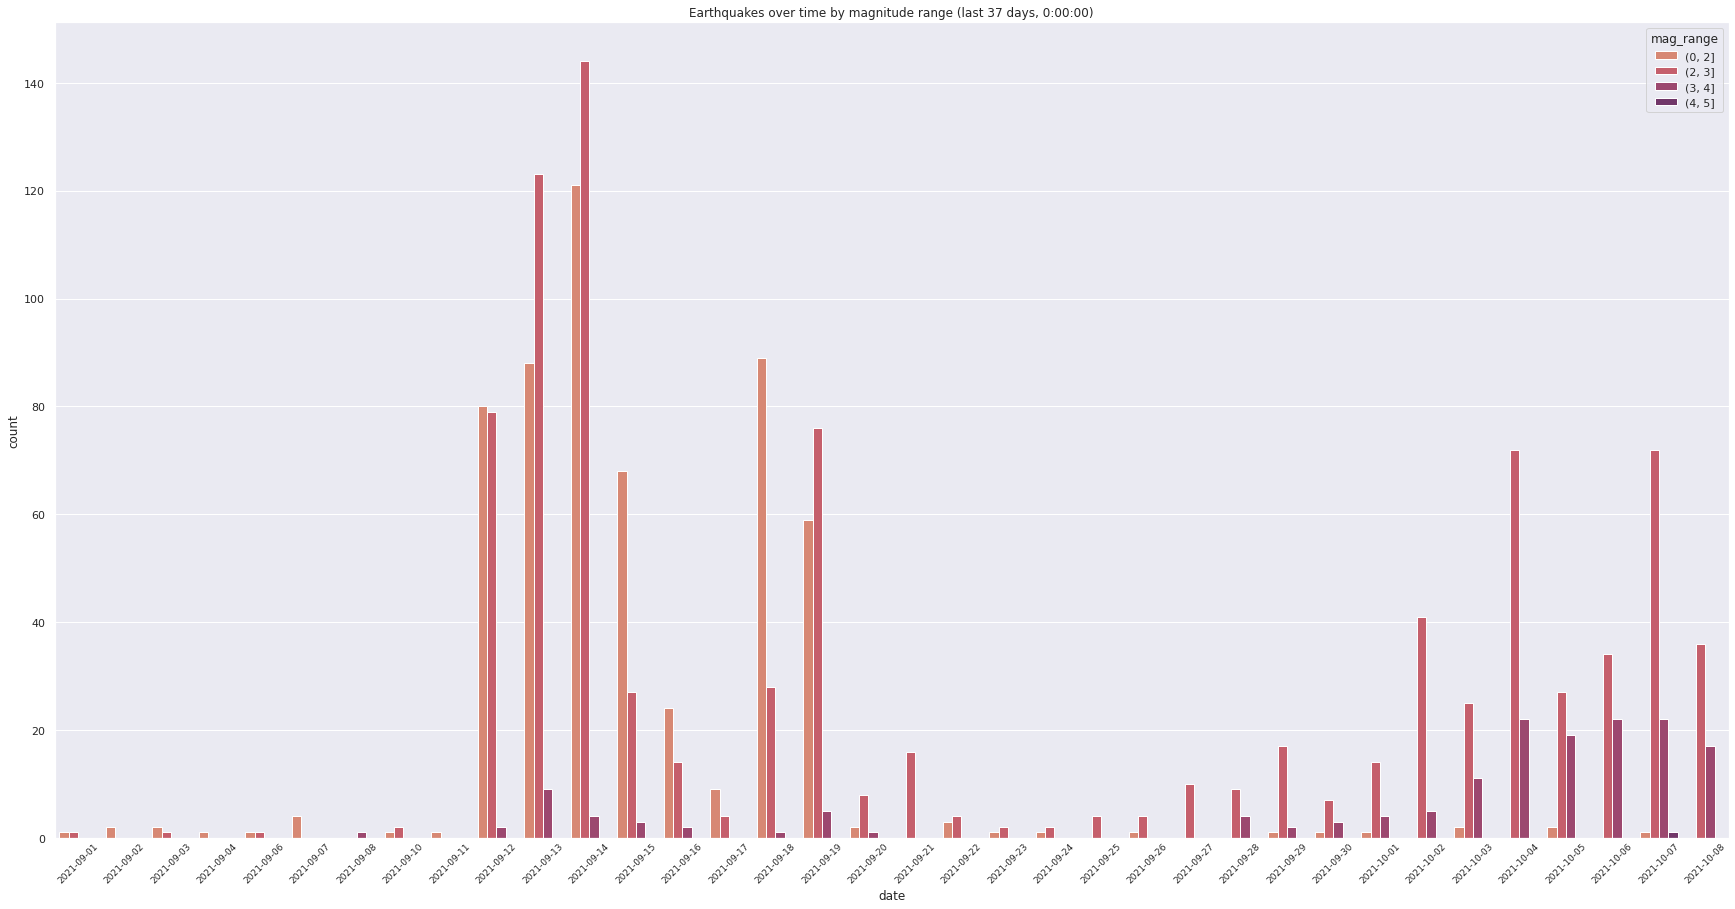

In [4]:
df = master_df[master_df["time"] >= dt(2021, 9, 1)]

fig, ax = plt.subplots()
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

ax.set_title(f"Earthquakes over time by magnitude range (last {df.iloc[0].date - df.iloc[-1].date})")
sns.countplot(data=df.sort_values("date"), x="date", palette="flare", hue="mag_range", hue_order=df["mag_range"].sort_values().unique(), dodge=True);

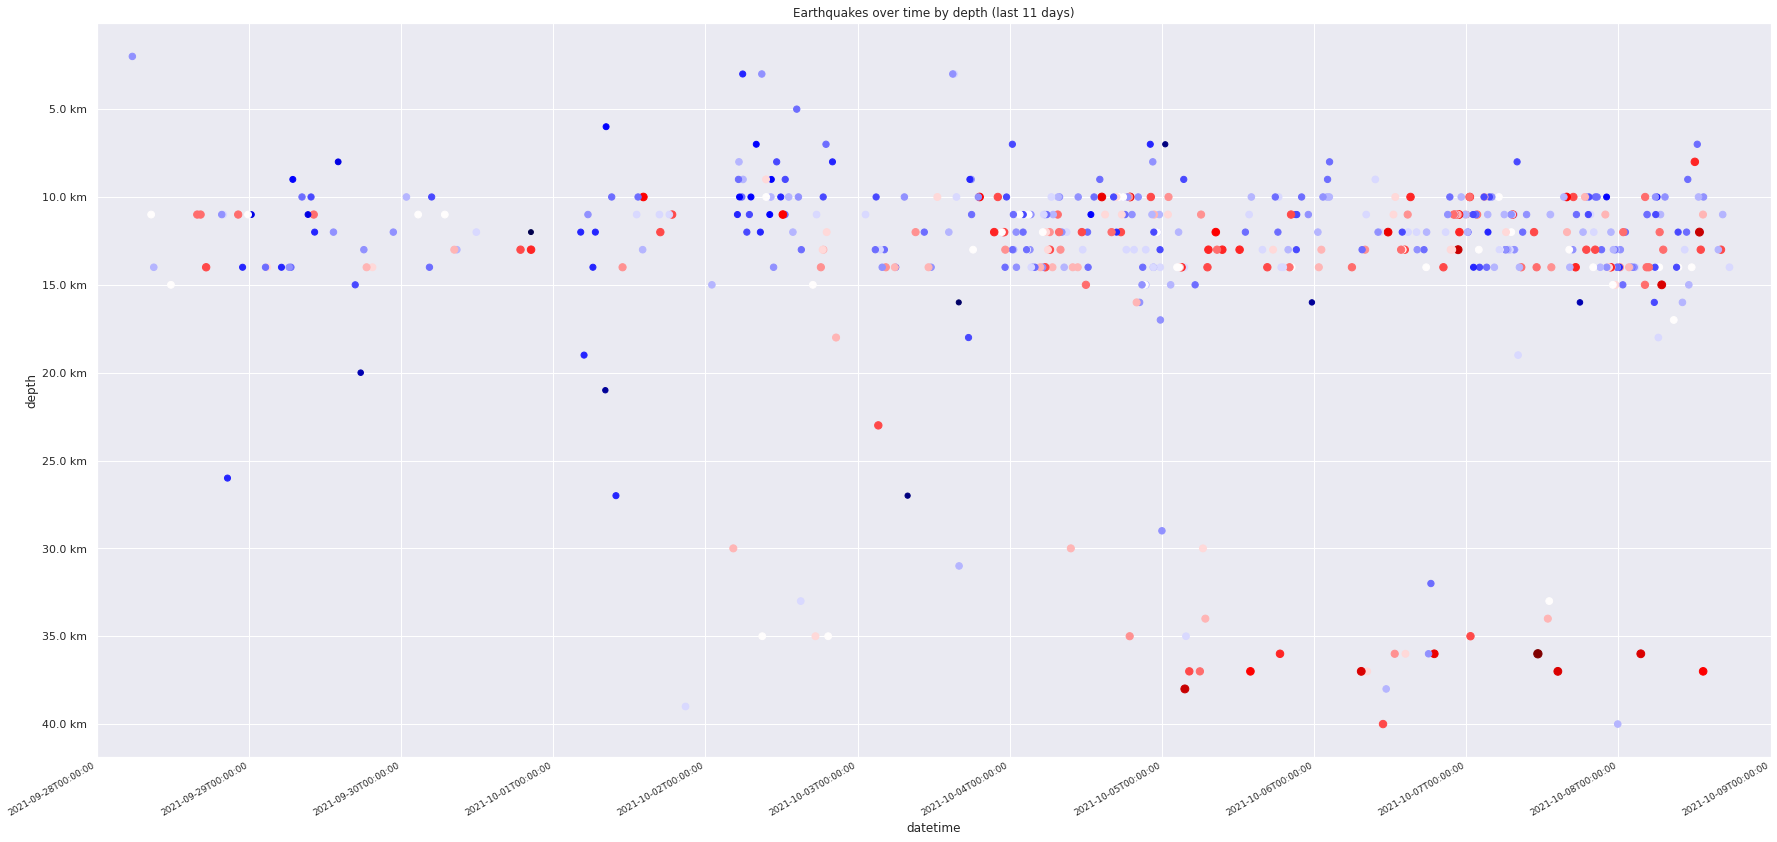

In [5]:
df = master_df[master_df["time"] >= dt(2021, 9, 28)]

fig, ax = plt.subplots()

ax.set_xlabel("datetime")
ax.set_ylabel("depth")
ax.scatter(df["time"], df["depth"], c=df["mag"], cmap="seismic", s=df["mag"] * 2 ** 4)
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

# Major ticks every day.
fmt_every_day = mdates.DayLocator(interval=1)
ax.xaxis.set_major_locator(fmt_every_day)

# Minor ticks every 6 hours.
fmt_hours = mdates.HourLocator(interval=6)
ax.xaxis.set_minor_locator(fmt_hours)

datemin = np.datetime64(df["time"].iloc[-1], 'D')
datemax = np.datetime64(df["time"].iloc[0], 'D') + np.timedelta64(1, 'D')
ax.set_xlim(datemin, datemax)
ax.set_title(f"Earthquakes over time by depth (last {datemax - datemin})")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%X'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))


ax.set_ylim(ax.get_ylim()[::-1])

ax.grid(True)
fig.autofmt_xdate()


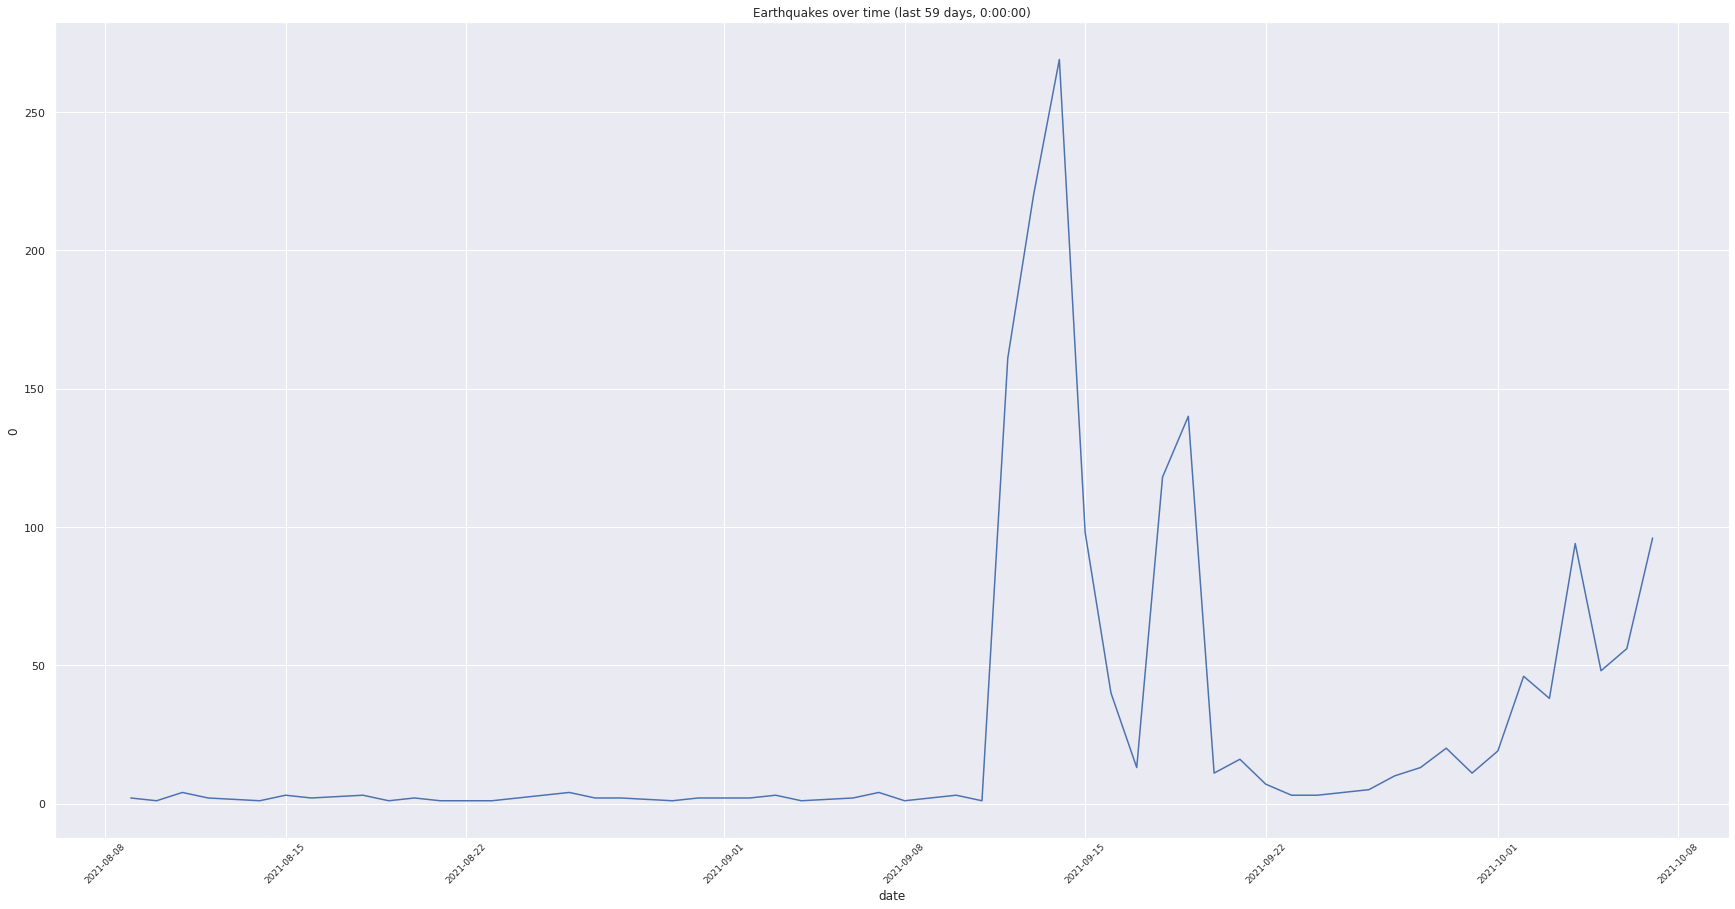

In [6]:
df = master_df[master_df["date"] < master_df.iloc[0].date]

fig, ax = plt.subplots()
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

ax.set_title(f"Earthquakes over time (last {df.iloc[0].date - df.iloc[-1].date})")

sns.lineplot(data=df.groupby("date").size().reset_index(), x="date", y=df.groupby("date").size().reset_index()[0]);

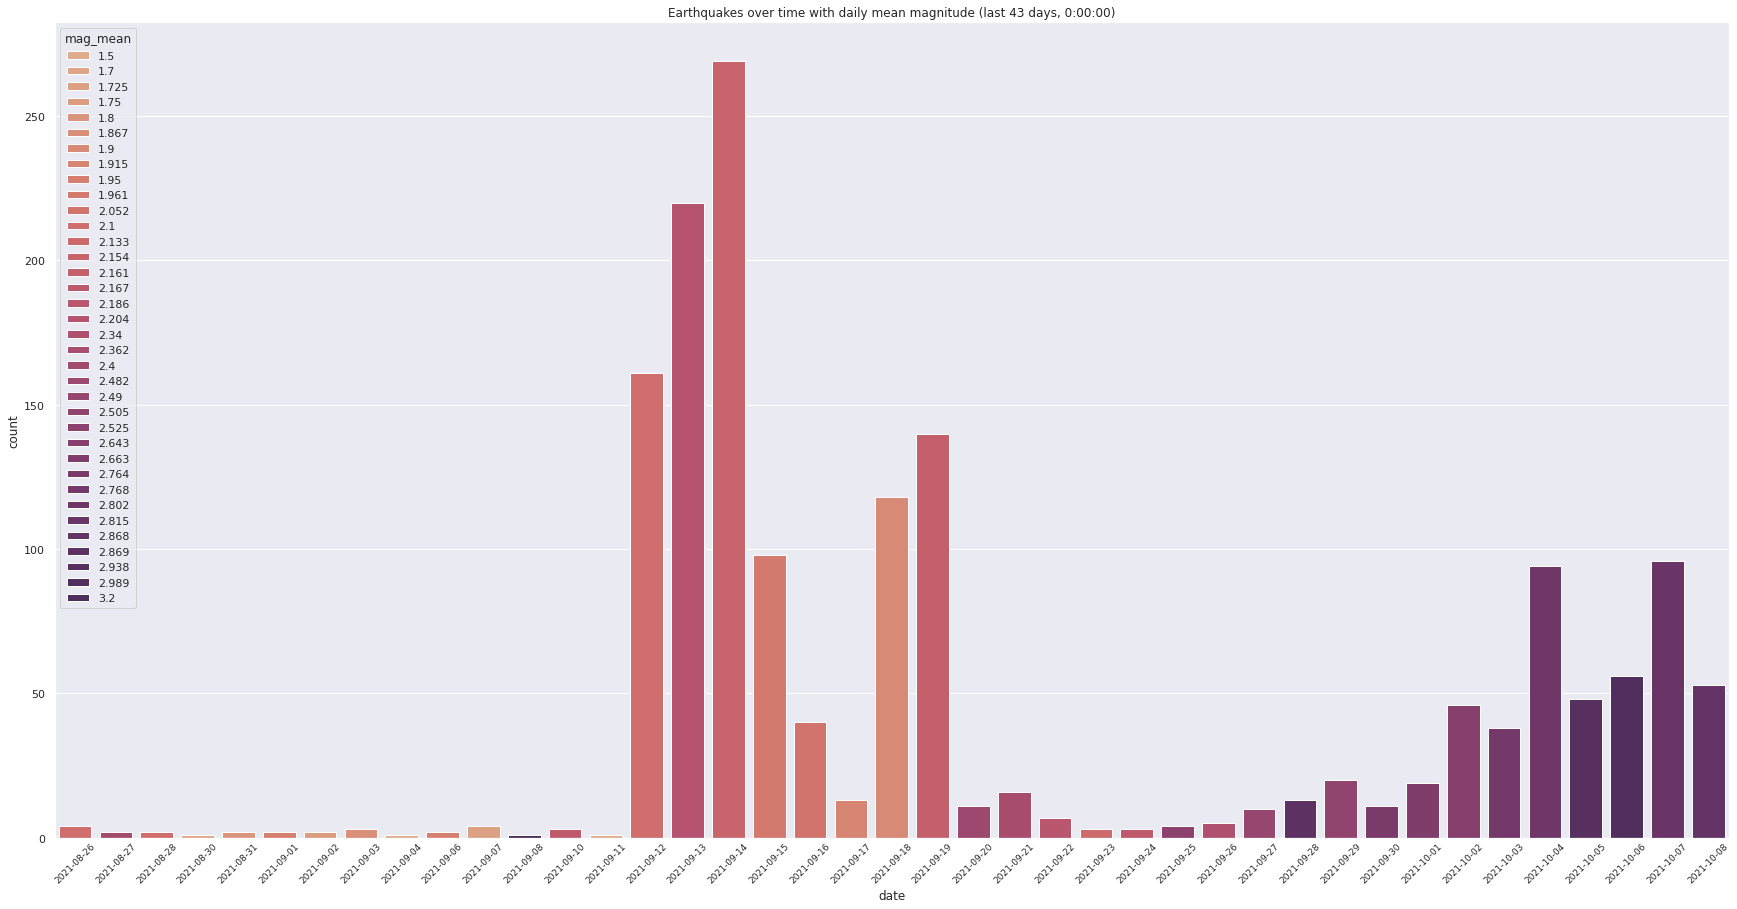

In [7]:
df = master_df[master_df["time"] >= dt.now() - timedelta(days=45)]

fig, ax = plt.subplots()
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")
ax.set_title(f"Earthquakes over time with daily mean magnitude (last {df.iloc[0].date - df.iloc[-1].date})")

sns.countplot(data=df.sort_values("date"), x="date", palette="flare", hue="mag_mean", dodge=False);